In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

import copy
from random import choice

import sys
np.set_printoptions(threshold=sys.maxsize)

In [2]:
# Main Constants

# Reference distance [m]
d0 = 1
# Constant for particular propagation enviroment
k = 1e-4
# Path Loss exponent
n = 4
# Total available bandwidth [Hz]
b_t = 100e6
# Constant for noise power [W/Hz]
k0 = 1e-20
# Side of a total area [m]
cov_side = 1e3

seeds = 1000

np.random.seed(42)

In [3]:
def eCDF(data):
    x = np.sort(data)
    y = np.arange(0, len(data)) / len(data)

    return x, y  

In [4]:
def lin2db(x):
    return 10.0*np.log10(x)

def db2lin(x):
    return 10.0**(x/10.0)

def lin2dbm(x):
    return 10.0*np.log10(x)+30.0

def dbm2lin(x):
    return 10.0**(x/10.0 - 3.0)

In [5]:
# Functions related to nodes positioning and distance

def random_position(cov_side):
    ''' 
    Returns a random position vector within the coverage area.
    
    Parameters
    ----------
    cov_side : int, float
        The side [in m] of the coverage area.
    '''
    
    x_pos = np.random.rand() * cov_side
    y_pos = np.random.rand() * cov_side
    
    return np.array([x_pos, y_pos])


def ap_position(num_ap, cov_side):
    ''' 
    Returns the APs positions based on the number of APs.
    
    Parameters
    ----------
    num_ap : int
        The number of APs.
    cov_side : int, float
        The side [in m] of coverage area.
    '''
    
    if np.sqrt(num_ap).is_integer():
        
        side_ap_quantity = int(np.sqrt(num_ap))
        
        ap_area_side = cov_side // side_ap_quantity
        
        x_pos, y_pos = np.meshgrid(np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side),
                                   np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side))
 
        aps_pos = np.column_stack((x_pos.ravel(), y_pos.ravel()))
    
        return aps_pos
    
    else:
        
        print('Number of APs must be a perfect square')

        
def distance(ue_pos, ap_pos, ref_distance=d0):
    ''' 
    Returns the distance [in m] between an UE and an AP. If distance is lower than reference distance, it returns the reference distance.
    
    Parameters
    ----------
    ue_pos : int, float
        The UE position.
    ref_distance : int, float
        The reference distance [in m] from which the gain is calculated.
    '''
    
    dis = np.sqrt((ue_pos[0] - ap_pos[0])**2
                  + (ue_pos[1] - ap_pos[1])**2)
    
    if dis >= ref_distance:
        return dis
    else:
        return ref_distance

In [6]:
# Functions related to channel modeling

def path_loss(distance2AP, prop_constant=k, ref_distance=d0):
    ''' 
    Returns the path loss [in dB] between an UE and an AP as defined by [emil2021].
    
    Parameters
    ----------
    distance2AP : int, float
        The distance between UE and AP.
    ref_distance : int, float
        The reference distance from which the path loss is calculated.
    '''
    
    gain = -lin2db(k) -10*n*np.log10(distance2AP)
    
    return gain

def shadowing(std):
    '''
    Returns the shadowing [in dB], which is a zero-mean lognormal distribution.
    
    Parameters
    ----------
    std : int, float
        The standard deviation of distribution. 
    '''
    
    return std*np.random.randn()

def channel(path_loss, shadowing, noise_g):
    '''
    Returns the channel [in linear] between an UE and an AP.
    
    Parameters
    ----------
    path_loss : int, float
        The path loss (or channel gain) [in dB] between an UE and an AP. 
    shadowing : int, float
        The shadowing effect [in dB] between an UE and an AP.
    noise_g : int, float
        The noise gain [in W] of system.
    '''
    
    return db2lin(path_loss + shadowing) / noise_g

def noise_g(noise_constant, bandwidth, noise_f=5):
    '''
    Returns the noise gain [in linear] in a system according to the badwidth that is being used.
   
    Parameters
    ----------
    noise_constant : int, float
        The noise constant [in W/Hz]  defined as k0 in the [Introduction to wireless ...].
    bandwidth : int, float
        The bandwidth [in Hz] available for the system.
    noise_f: int, flot
        The ... (default is 9 [dB])
    '''
    
    return noise_constant * bandwidth * db2lin(noise_f)

In [7]:
# Functions related to power

def received_power(t_power, channel):
    '''
    Returns the received power [in W] by an AP transmitted by an UE considering the channel between them
    
    Parameters
    ----------
    t_power : int, float
        Power transmitted [in W] by UE.
    channel : int, float
        Channel between UE and AP [in linear].
    '''
    
    return t_power * channel

def noise_p(noise_constant, bandwidth):
    '''
    Returns the noise power [in W] in a system according to the badwidth that is being used.
   
    Parameters
    ----------
    noise_constant : int, float
        The noise constant [in W/Hz]  defined as k0 in the [Introduction to wireless ...].
    bandwidth : int, float
        The bandwidth [in Hz] available for the system.
    '''
    
    return noise_constant * bandwidth

In [8]:
def combiner(channel_m, noise_gain, t_power):

    v = np.zeros(channel_m.shape); sum = 0

    for ue in range(channel_m.shape[0]):
        sum += channel_m[ue,:] @ channel_m[ue,:].T

    for ue in range(channel_m.shape[0]):
        v[ue] = (t_power[ue] * (sum - channel_m[ue,:] @ channel_m[ue,:].T)**(-1) + noise_gain**2) * channel_m[ue]

    return v
        
def sinr(v, t_power, channel_m, noise_p):
    '''
    Returns the signal-to-interference-plus-noise [in linear] ratio in a cell-free scenario according to [Emil2021]
    
    Parameters
    ----------
    k : int
        The user whose the sinr is being calculated.
    t_power : int, float
        The power [in W] of the user.
     channel_matrix : numpy matrix
        The matrix containing the channels [in linear] of every link in the system, the matrix shape must be
        num_ue x num_ap.
    noise_p : int, float
        The system noise power [in W].
    '''
    
    sinr = np.zeros(len(channel_m))
    
    # Does the sum of the products between a matrix and its hermetian for all users but the one in interest.
    channel_sum = 0
    
    for ue in range(len(channel_m)):
        channel_sum += channel_m[ue,:] @ channel_m[ue,:].T

    # channel_sum -= channel_matrix[k] @ channel_matrix[k].T
    
    for ue in range(len(channel_m)):
  
        # interest = np.abs(v[ue,:].T @ channel_m[ue])**2 * t_power[ue]
        # interfering = ((t_power[ue] * (channel_sum - (channel_m[ue] @ channel_m[ue].T)) + noise_p**2) * (v[ue,:].T @ v[ue,:]))
        
        # sinr[ue] = interest/interfering

        inv_term = ((t_power[ue]*(channel_sum - (channel_m[ue,:] @ channel_m[ue,:].T))) + noise_p**2)**(-1)
        sinr[ue] = t_power[ue] * channel_m[ue,:].T * inv_term @ channel_m[ue,:]
        
    #print(sinr)    
    return sinr

In [51]:
def sinr_mmse_cell_free(h, power, sigma_n):

    h_sum = 0
    for k in range(h.shape[0]):
        h_sum += np.outer(h[k,:], h[k,:].T.conj()) # To be used in the denominator of SINR
    
    sinr_mmse_cell_free = np.zeros((h.shape[0]))
    
    for ue in range(h.shape[0]):
        # D-MIMO channel of j-th UE
        
        R = np.linalg.inv(power[ue] * (h_sum - np.outer(h[ue,:], h[ue,:].T.conj())) + sigma_n**2 * np.eye(h.shape[1]))
        #sinr_mmse_cell_free[ue] = np.abs(power[ue] * np.dot(h[ue,:].T.conj(), np.linalg.solve(R, h[ue,:])))
        sinr_mmse_cell_free[ue] = power[ue] * h[ue,:].T.conj() @ R @ h[ue,:]


    return np.abs(sinr_mmse_cell_free)

In [10]:
def capacity(bandwidth, sinr):
    '''
    Returns te capacity [in Mbps], the data rate of system.

    Parameters
    ----------
    bandwidth : int, float
        The bandwidth [in Hz] available for the system.
    sinr : int, float
        The SINR [in linear] of the link in question.
    '''
    
    return (bandwidth * np.log2(1 + sinr)) / 1e6

In [11]:
def fractional_power_control(gain_matrix, max_power, compensation_factor=0.6, target_power=0):

    power_vector = np.zeros((gain_matrix.shape[0]))
    
    for p in range(gain_matrix.shape[0]):
        beta_i = 0
        
        for ap in range(gain_matrix.shape[0]):
            
            beta_i += np.outer(gain_matrix[p,ap], gain_matrix[p,ap].T) 
        
        # zeta as defined in article (how to cite?)
        # zeta = np.sqrt(sum(G[i]))
        # new_transmitted_power = db2lin(target_power) * zeta**(-compensation_factor)

        power_vector[p] = np.min([max_power, db2lin(target_power)*np.sqrt(np.trace(beta_i))**(-compensation_factor)])        
        power_vector[p] = db2lin(target_power)*np.sqrt(np.trace(beta_i))**(-compensation_factor)        
    
    
    return power_vector

In [12]:
def stepwise_removal(gain_matrix):

    matrix_Z = np.zeros((gain_matrix.shape[0], gain_matrix.shape[0]))
    gain_array = np.zeros(gain_matrix.shape[0])

    aux_gain_matrix = copy.deepcopy(gain_matrix)
    
    for i in range(gain_matrix.shape[0]):
        gain_array[i] = sum(gain_matrix[i])

    for i in range(gain_matrix.shape[0]):
        matrix_Z[i] = gain_array / gain_array[i]
    
    target_SINR = db2lin(-10) 
    
    while True:

        eigenvalues_matrix = np.linalg.eig(matrix_Z)[0]
        eigenvector_matrix = np.linalg.eig(matrix_Z)[1]
        
        max_eigenvalue = eigenvalues_matrix.max()
        index = np.where(eigenvalues_matrix == max_eigenvalue)
        
        max_eigenvector = eigenvector_matrix[index] 
        
        max_achievable_SINR = 1 / (max_eigenvalue - 1)
       

        if max_achievable_SINR >= target_SINR:
            
            power_vector = max_eigenvector
            break
            
        else:

            max_value = float('-inf')
            max_j = 0

            for j in range(matrix_Z.shape[0]):
             
                soma = sum(matrix_Z[j]) + sum(np.transpose(matrix_Z)[j])

                if soma > max_value:
                    max_value = soma
                    max_j = j

            matrix_Z = np.delete(matrix_Z, max_j, 0)
            matrix_Z = np.delete(matrix_Z, max_j, 1) 
            aux_gain_matrix = np.delete(aux_gain_matrix, max_j, 0)

    return power_vector, aux_gain_matrix

In [52]:
num_ue = 10
total_sinr_fpc = np.zeros((num_ue, seeds))
total_sinr_mp = np.zeros((num_ue, seeds))
total_sinr_sra = np.zeros((num_ue, seeds))

total_ee_mp = np.zeros((num_ue, seeds))
total_ee_sra = np.zeros((num_ue, seeds))

max_power = 1 # [W}

for seed in range(seeds):

    ue_pos_vector = []

    for UE in range(num_ue):
        ue_pos_vector.append(random_position(cov_side))

    ap_pos = ap_position(16, cov_side)


    # Noise constants
    noise_gain = noise_g(k0, b_t, noise_f=5)
    noise_power = noise_p(k0, b_t)


    # The matrixes
    distance_matrix = np.zeros((num_ue, 
                                len(ap_pos)))
    path_loss_matrix = np.zeros((num_ue, 
                                 len(ap_pos)))
    shadowing_matrix = np.zeros((num_ue, 
                                 len(ap_pos)))
    channel_matrix = np.zeros((num_ue, 
                               len(ap_pos)))


    for i in range(num_ue):
        for j in range(len(ap_pos)):

            distance_matrix[i, j] = distance(ue_pos_vector[i], 
                                             ap_pos[j])

            shadowing_matrix[i, j] = shadowing(2) # std = 2

    path_loss_matrix = path_loss(distance_matrix)

    channel_matrix = channel(path_loss_matrix,
                             shadowing_matrix,
                             noise_gain)
        
    power_vector_mp = max_power*np.ones(num_ue)
    #power_vector_fpc = fractional_power_control(channel_matrix, max_power, compensation_factor=0.8, target_power=-10)
    power_vector_sra = np.abs(np.real(stepwise_removal(channel_matrix)[0])[0])
    sra_channel_matrix = stepwise_removal(channel_matrix)[1]
    
    print('seed', seed)
    #clear_output(wait=True)

    v_mp = combiner(channel_matrix, noise_gain, power_vector_mp)
    #v_fpc = combiner(channel_matrix, noise_gain, power_vector_fpc)
    v_sra = combiner(channel_matrix, noise_gain, power_vector_sra)

    
    for UE in range(num_ue):
        total_sinr_mp[:, seed] = sinr_mmse_cell_free(channel_matrix, power_vector_mp, noise_gain)
     #  total_sinr_fpc[:, seed] = sinr_mmse_cell_free(channel_matrix, power_vector_fpc, noise_gain)
        #total_sinr_sra[:, seed] = sinr_mmse_cell_free(channel_matrix, power_vector_sra, noise_gain)
    clear_output(wait=True)

seed 1


LinAlgError: Singular matrix

In [46]:
mean_sinr_mp = lin2db(np.mean(total_sinr_mp, axis=0))
ac_sinr_mp = lin2db(total_sinr_mp)

# mean_sinr_fpc = lin2db(np.mean(total_sinr_fpc, axis=0))
# ac_sinr_fpc = lin2db(total_sinr_fpc)

mean_sinr_sra = lin2db(np.mean(total_sinr_sra, axis=0))
ac_sinr_sra = lin2db(total_sinr_sra)

In [47]:
mean_capacity_mp = capacity(b_t, db2lin(mean_sinr_mp))
ac_capacity_mp = capacity(b_t, db2lin(ac_sinr_mp))

# mean_capacity_fpc = capacity(b_t, db2lin(mean_sinr_fpc))
# ac_capacity_fpc = capacity(b_t, db2lin(ac_sinr_fpc))

mean_capacity_sra = capacity(b_t, db2lin(mean_sinr_sra))
ac_capacity_sra = capacity(b_t, db2lin(ac_sinr_sra))

In [ ]:
mean_ee_mp = np.mean(total_ee_mp, axis=0)
ac_ee_mp = total_ee_mp

mean_ee_sra = np.mean(total_ee_sra, axis=0)
ac_ee_sra = total_ee_sra

In [ ]:
ee_mp_CDF = eCDF(mean_ee_mp.flatten())
plt.plot(ee_mp_CDF[0], ee_mp_CDF[1], label = 'max power')

# sinr_fpc_CDF = eCDF(mean_sinr_fpc.flatten())
# plt.plot(sinr_fpc_CDF[0], sinr_fpc_CDF[1], label = 'SINR fractional power control')

ee_sra_CDF = eCDF(mean_ee_sra.flatten())
plt.plot(ee_sra_CDF[0], ee_sra_CDF[1], label = 'stepwise removal')

plt.xlabel('Mean Energy Efficiency [Mbps/W]')
plt.ylabel('ecdf')

plt.legend()
plt.grid()
plt.title('Mean Energy Efficiency')
#plt.savefig('sinr_fpc_06_68.png')

In [ ]:
ac_ee_mp_CDF = eCDF(ac_ee_mp.flatten())
plt.plot(ac_ee_mp_CDF[0], ac_ee_mp_CDF[1], label = 'max power')

# ac_sinr_fpc_CDF = eCDF(ac_sinr_fpc.flatten())
# plt.plot(ac_sinr_fpc_CDF[0], ac_sinr_fpc_CDF[1], label = 'SINR fractional power control')

ac_ee_sra_CDF = eCDF(ac_ee_sra.flatten())
plt.plot(ac_ee_sra_CDF[0], ac_ee_sra_CDF[1], label = 'stepwise removal')

plt.xlabel('Energy Efficiency [Mbps/W]')
plt.ylabel('ecdf')

plt.title('Energy Efficiency')
plt.legend()
plt.grid()

Text(0.5, 1.0, 'mean SINR')

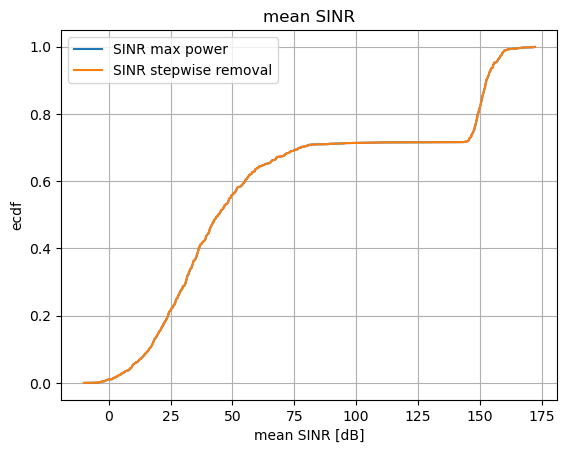

In [48]:
sinr_mp_CDF = eCDF(mean_sinr_mp.flatten())
plt.plot(sinr_mp_CDF[0], sinr_mp_CDF[1], label = 'SINR max power')

# sinr_fpc_CDF = eCDF(mean_sinr_fpc.flatten())
# plt.plot(sinr_fpc_CDF[0], sinr_fpc_CDF[1], label = 'SINR fractional power control')

sinr_sra_CDF = eCDF(mean_sinr_sra.flatten())
plt.plot(sinr_sra_CDF[0], sinr_sra_CDF[1], label = 'SINR stepwise removal')

plt.xlabel('mean SINR [dB]')
plt.ylabel('ecdf')

plt.legend()
plt.grid()
plt.title('mean SINR')
#plt.savefig('sinr_fpc_06_68.png')

Text(0.5, 1.0, 'mean Capacity')

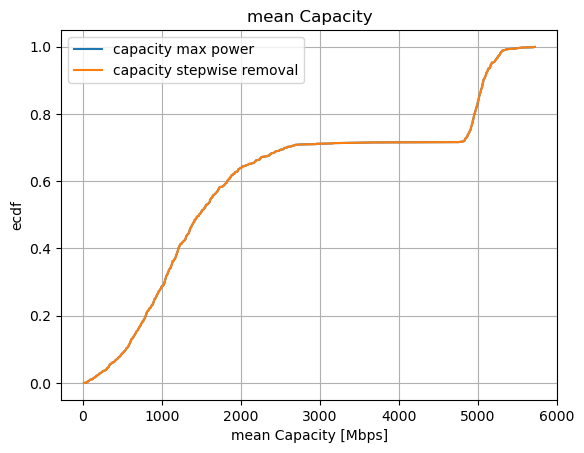

In [49]:
capacity_mp_CDF = eCDF(mean_capacity_mp.flatten())
plt.plot(capacity_mp_CDF[0], capacity_mp_CDF[1], label = 'capacity max power')

# capacity_fpc_CDF = eCDF(mean_capacity_fpc.flatten())
# plt.plot(capacity_fpc_CDF[0], capacity_fpc_CDF[1], label = 'capacity fractional power control')

capacity_sra_CDF = eCDF(mean_capacity_sra.flatten())
plt.plot(capacity_sra_CDF[0], capacity_sra_CDF[1], label = 'capacity stepwise removal')

plt.legend()
plt.grid()
plt.xlabel('mean Capacity [Mbps]')
plt.ylabel('ecdf')

plt.title('mean Capacity')
#plt.savefig('capacity_fpc_06_68.png')

In [ ]:
ac_sinr_mp_CDF = eCDF(ac_sinr_mp.flatten())
plt.plot(ac_sinr_mp_CDF[0], ac_sinr_mp_CDF[1], label = 'SINR max power')

# ac_sinr_fpc_CDF = eCDF(ac_sinr_fpc.flatten())
# plt.plot(ac_sinr_fpc_CDF[0], ac_sinr_fpc_CDF[1], label = 'SINR fractional power control')

ac_sinr_sra_CDF = eCDF(ac_sinr_sra.flatten())
plt.plot(ac_sinr_sra_CDF[0], ac_sinr_sra_CDF[1], label = 'SINR stepwise removal')

plt.xlabel('SINR [dB]')
plt.ylabel('ecdf')

plt.title('SINR')
plt.legend()
plt.grid()

In [ ]:
ac_capacity_mp_CDF = eCDF(ac_capacity_mp.flatten())
plt.plot(ac_capacity_mp_CDF[0], ac_capacity_mp_CDF[1], label = 'Capacity max power')

# ac_capacity_fpc_CDF = eCDF(ac_capacity_fpc.flatten())
# plt.plot(ac_capacity_fpc_CDF[0], ac_capacity_fpc_CDF[1], label = 'Capacity fractional power control')

ac_capacity_sra_CDF = eCDF(ac_capacity_sra.flatten())
plt.plot(ac_capacity_sra_CDF[0], ac_capacity_sra_CDF[1], label = 'Capacity stepwise removal')

plt.legend()
plt.grid()
plt.xlabel('Capacity [Mbps]')
plt.ylabel('ecdf')

plt.title('Capacity')